* check performance with sliding window on/off
* check performance with binary vs float labels
* check performance with different ticker price windows and corresponding feature windows

Other idea for catagorical label generation
* predict on x intervals for movement in the next y interval of time. e.g. using intervals of 6 hours predict the movement in the next 12-24 hours 


# Check that GPU is listed for tensorflow

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4625625480794331212
]


# Load Ticker Data

In [3]:
import pandas as pd

In [4]:
eth_ticker_raw = pd.read_csv("data/ticker_data/USDT_ETH.csv",index_col=0).rename(columns={"Timestamp":"timestamp"})
btc_ticker_raw = pd.read_csv("data/ticker_data/USDT_BTC.csv",index_col=0).rename(columns={"Timestamp":"timestamp"})          

In [5]:
eth_ticker_raw[eth_ticker_raw.timestamp == 1439014500]

,Close,timestamp,High,Low,Open
0,1.75,1439014500,0.33,1.61,0.33


In [6]:
btc_ticker_raw[btc_ticker_raw.timestamp == 1439014500]

,Close,timestamp,High,Low,Open
48805,273.947811,1439014500,275.603572,273.947811,275.603572


In [7]:
btc_ticker_raw.head()

,Close,timestamp,High,Low,Open
0,225.0,1424373000,0.33,225.0,0.33
1,225.0,1424373300,225.00,225.0,225.00
2,225.0,1424373600,225.00,225.0,225.00
3,225.0,1424373900,225.00,225.0,225.00
4,225.0,1424374200,225.00,225.0,225.00


In [8]:
# sync the times of the two dataframes

# Shape ticker data for features

* align the btc and eth data
* write function that can create data point windows - 5 minutes, 20 minutes, 6 hours
* create features and outputs

## Align Data

In [9]:
ticker_data_merged = eth_ticker_raw.set_index("timestamp")\
                .join(
                        btc_ticker_raw.set_index("timestamp"),
                        on="timestamp",
                        how="inner",
                        lsuffix="_eth",
                        rsuffix="_btc")

In [10]:
ticker_data_merged.head()

,Close_eth,High_eth,Low_eth,Open_eth,Close_btc,High_btc,Low_btc,Open_btc
timestamp,,,,,,,,
1439014500,1.75,0.33,1.61,0.33,273.947811,275.603572,273.947811,275.603572
1439014800,1.85,1.85,1.85,1.85,273.905543,273.905543,273.626238,273.901814
1439015100,1.85,1.85,1.85,1.85,273.905543,273.905543,273.905543,273.905543
1439015400,1.85,1.85,1.85,1.85,273.917572,273.917572,273.917572,273.917572
1439015700,1.85,1.85,1.85,1.85,273.917572,273.917572,273.917572,273.917572


## Modify Time Spans

In [11]:
ticker_data_merged.dtypes

Close_eth    float64
High_eth     float64
Low_eth      float64
Open_eth     float64
Close_btc    float64
High_btc     float64
Low_btc      float64
Open_btc     float64
dtype: object

In [12]:
import numpy as np

# in minutes 
minutes = 10
data_point_bucket_size = str(minutes) + "T"

datetime = pd.to_datetime(ticker_data_merged.index,unit='s') 


agg_method = {'Close_eth': "last",
                "High_eth": np.max, 
                "Low_eth": np.min,
                "Open_eth": "first",
                "Close_btc": "last",
                "High_btc": np.max, 
                "Low_btc": np.min,
                "Open_btc": "first", 
                 }

ticker_data = ticker_data_merged.set_index(datetime)\
                                    .resample(data_point_bucket_size)\
                                    .agg(agg_method)

print("Shape of reshaped data: " + str(ticker_data.shape))
print("Shape of original data: " + str(ticker_data_merged.shape))

Shape of reshaped data: (150216, 8)
Shape of original data: (300430, 8)


In [13]:
ticker_data.head()

,Close_eth,High_eth,Low_eth,Open_eth,Close_btc,High_btc,Low_btc,Open_btc
timestamp,,,,,,,,
2015-08-08 06:10:00,1.75,0.33,1.61,0.33,273.947811,275.603572,273.947811,275.603572
2015-08-08 06:20:00,1.85,1.85,1.85,1.85,273.905543,273.905543,273.626238,273.901814
2015-08-08 06:30:00,1.85,1.85,1.85,1.85,273.917572,273.917572,273.917572,273.917572
2015-08-08 06:40:00,1.85,1.85,1.85,1.85,273.917572,273.917572,273.917572,273.917572
2015-08-08 06:50:00,1.71,1.71,1.71,1.71,274.155050,274.155050,274.155050,274.155050


## * Adding Sentiment information

From the research it looked like sentiments from 4-2 days ago yielded the best results.
* I need to consider different time intervals and how i will slide the data?

In [14]:
import pandas as pd

In [15]:
sentiment = pd.read_parquet("data/features/sentiment_features")
sentiment.head(5000).dropna()

,avg_reddit_eth_compound_vader,avg_reddit_eth_pos_vader,avg_reddit_eth_neg_vader,avg_reddit_eth_polarity_textblob,avg_reddit_eth_subjectivity_textblob,avg_reddit_btc_compound_vader,avg_reddit_btc_pos_vader,avg_reddit_btc_neg_vader,avg_reddit_btc_polarity_textblob,avg_reddit_btc_subjectivity_textblob,...,avg_4day_twitter_btc_compound_vader,avg_4day_twitter_btc_pos_vader,avg_4day_twitter_btc_neg_vader,avg_4day_twitter_btc_polarity_textblob,avg_4day_twitter_btc_subjectivity_textblob,avg_4day_twitter_compound_vader,avg_4day_twitter_pos_vader,avg_4day_twitter_neg_vader,avg_4day_twitter_polarity_textblob,avg_4day_twitter_subjectivity_textblob
2016-01-05 00:00:00,0.921400,0.802000,0.288000,0.629557,0.533333,0.539011,0.205667,0.085625,0.127882,0.417544,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05 00:10:00,0.222350,0.566000,0.314500,0.089779,0.641667,0.488052,0.182302,0.081590,0.140953,0.501798,...,0.609873,0.293585,0.153375,0.167216,0.262328,0.609355,0.293298,0.153375,0.182638,0.264452
2016-01-05 00:20:00,-0.476700,0.330000,0.341000,-0.450000,0.750000,0.437094,0.158937,0.077556,0.154024,0.586052,...,0.592523,0.292128,0.155138,0.182643,0.277187,-0.058188,0.288767,0.151118,0.250259,0.547621
2016-01-05 00:30:00,0.659700,0.094000,0.270250,0.104167,0.245833,0.109513,0.126000,0.172467,0.078175,0.506584,...,0.575172,0.290671,0.156902,0.198070,0.292047,-0.027525,0.229029,0.152429,0.285345,0.534792
2016-01-05 00:40:00,0.704967,0.097000,0.199500,0.093287,0.369213,0.155755,0.138048,0.152111,0.100183,0.483497,...,0.557821,0.289215,0.158665,0.213497,0.306906,0.351197,0.196920,0.198200,0.385520,0.537183
2016-01-05 00:50:00,0.750233,0.100000,0.128750,0.082407,0.492593,0.201996,0.150095,0.131756,0.122192,0.460409,...,0.540471,0.287758,0.160429,0.228924,0.321766,0.474006,0.252839,0.154000,0.296414,0.531020
2016-01-05 01:00:00,0.795500,0.103000,0.058000,0.071528,0.615972,0.248237,0.162143,0.111400,0.144201,0.437322,...,0.523120,0.286301,0.162192,0.244350,0.336625,0.405348,0.223650,0.150333,0.256415,0.445263
2016-01-05 01:10:00,0.819950,0.161000,0.016000,0.288907,0.627958,0.246671,0.154571,0.099600,0.082043,0.458287,...,0.505770,0.284844,0.163956,0.259777,0.351484,0.592418,0.272787,0.190800,0.163267,0.279567
2016-01-05 01:20:00,0.825612,0.183500,0.043800,0.288555,0.589719,0.013919,0.129429,0.133800,0.107683,0.475771,...,0.488419,0.283387,0.165719,0.275204,0.366344,0.315339,0.226346,0.313600,0.136164,0.496957
2016-01-05 01:30:00,0.831275,0.206000,0.071600,0.288203,0.551479,-0.218834,0.104286,0.168000,0.133324,0.493255,...,0.471068,0.281930,0.167483,0.290631,0.381203,0.383664,0.246414,0.162000,0.094220,0.507014


In [16]:
sentiment.index.name = "timestamp"

In [17]:
sentiment.head()

,avg_reddit_eth_compound_vader,avg_reddit_eth_pos_vader,avg_reddit_eth_neg_vader,avg_reddit_eth_polarity_textblob,avg_reddit_eth_subjectivity_textblob,avg_reddit_btc_compound_vader,avg_reddit_btc_pos_vader,avg_reddit_btc_neg_vader,avg_reddit_btc_polarity_textblob,avg_reddit_btc_subjectivity_textblob,...,avg_4day_twitter_btc_compound_vader,avg_4day_twitter_btc_pos_vader,avg_4day_twitter_btc_neg_vader,avg_4day_twitter_btc_polarity_textblob,avg_4day_twitter_btc_subjectivity_textblob,avg_4day_twitter_compound_vader,avg_4day_twitter_pos_vader,avg_4day_twitter_neg_vader,avg_4day_twitter_polarity_textblob,avg_4day_twitter_subjectivity_textblob
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-05 00:00:00,0.921400,0.802,0.28800,0.629557,0.533333,0.539011,0.205667,0.085625,0.127882,0.417544,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05 00:10:00,0.222350,0.566,0.31450,0.089779,0.641667,0.488052,0.182302,0.081590,0.140953,0.501798,...,0.609873,0.293585,0.153375,0.167216,0.262328,0.609355,0.293298,0.153375,0.182638,0.264452
2016-01-05 00:20:00,-0.476700,0.330,0.34100,-0.450000,0.750000,0.437094,0.158937,0.077556,0.154024,0.586052,...,0.592523,0.292128,0.155138,0.182643,0.277187,-0.058188,0.288767,0.151118,0.250259,0.547621
2016-01-05 00:30:00,0.659700,0.094,0.27025,0.104167,0.245833,0.109513,0.126000,0.172467,0.078175,0.506584,...,0.575172,0.290671,0.156902,0.198070,0.292047,-0.027525,0.229029,0.152429,0.285345,0.534792
2016-01-05 00:40:00,0.704967,0.097,0.19950,0.093287,0.369213,0.155755,0.138048,0.152111,0.100183,0.483497,...,0.557821,0.289215,0.158665,0.213497,0.306906,0.351197,0.196920,0.198200,0.385520,0.537183


## Construct % price change label

In [18]:
eth_close_percent_change = ticker_data.Close_btc.pct_change()
ticker_data["eth_close_percent_change"] = eth_close_percent_change

In [19]:
ticker_data.dtypes

Close_eth                   float64
High_eth                    float64
Low_eth                     float64
Open_eth                    float64
Close_btc                   float64
High_btc                    float64
Low_btc                     float64
Open_btc                    float64
eth_close_percent_change    float64
dtype: object

## * Construct Binary label to capture up or down movement between days

# specify the output
#close_ethb

In [20]:
nothing_changed = ticker_data.eth_close_percent_change.round(decimals=6) == 0
negative_change = ticker_data.eth_close_percent_change.round(decimals=6) < 0
positive_change = ticker_data.eth_close_percent_change.round(decimals=6) > 0



In [21]:
ticker_data["eth_close_movement"] = -9

ticker_data["eth_close_movement"][positive_change] = 1 
ticker_data["eth_close_movement"][nothing_changed] = 0
ticker_data["eth_close_movement"][negative_change] = -1

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [22]:
ticker_data = ticker_data[~ticker_data.eth_close_percent_change.isnull()]

In [23]:
ticker_data = ticker_data.join(sentiment,how="inner")

**Key**
* -1 went down
* 0 stayed the same
* 1 went up

# Construction of Features & Labels

The features I care about:
* eth closing
* btc closing
* eth closing 3 days ago
* eth closing 4 days ago
* btc closing 3 days ago
* btc closing 4 days ago
* sentiment for 3 days ago
* sentiment for 4 days ago

The ratio of features to labels will be 16. And 6 days worth of data needs to be read at a time. This is in line with the research on sentiment analysis. 

For example:
* If the 5 minute intervals are used then the number of features need to be +- 1728 (8640 minutes) and the vector size of the label will be 108 (540 minutes or 9 hours)

**Temporal Golden Rule 1:**
* Temporal order must be preserved. Your features can not be further in time then your labels. 

**NOTE** the above should be doubled as the btc and eth values will be in the input layer

In [24]:
data_point_window = 5
days = 6
feature_vector_size = 6*24*60/data_point_window
output_vector_size = feature_vector_size/16

output_vector_minutes_span = output_vector_size*5
output_vector_hour_span = output_vector_minutes_span/60

print("Number of days feature vector will cover: " + str(days))
print("Data Point Window Size: " + str(data_point_window) + " minutes")
print("Size of feature vector: " + str(feature_vector_size))
print()
print("Number of minutes output vector will cover: " + str(output_vector_minutes_span))
print("Number of hours output vector will cover: " + str(output_vector_hour_span))
print("Size of output vector: " + str(output_vector_size))


Number of days feature vector will cover: 6
Data Point Window Size: 5 minutes
Size of feature vector: 1728.0

Number of minutes output vector will cover: 540.0
Number of hours output vector will cover: 9.0
Size of output vector: 108.0


The following class was obtained from [the following blog](https://nicholastsmith.wordpress.com/2017/11/13/cryptocurrency-price-prediction-using-deep-learning-in-tensorflow/)

In [100]:
##QUESTION!!!!???? bias introduced in the label if there is overlap with the next training row?

import numpy as np
import pandas as pd
 
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        if self.sliding_window:
            slide_windows_size = 6
            I = np.arange(M) + np.arange(A.shape[0] - M,step=slide_windows_size).reshape(-1, 1)
        else:
            if A.shape[0]%M == 0:
                I = np.arange(M)+np.arange(0,A.shape[0],M).reshape(-1,1)
                
            else:
                I = np.arange(M)+np.arange(0,A.shape[0] -M,M).reshape(-1,1)
            
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix



In [94]:
K = NPS 
N = NFS
M = N + K
slide_windows_size = 6
I = np.arange(M) + np.arange(A.shape[0] - M,step=slide_windows_size).reshape(-1, 1)

In [95]:
np.arange(A.shape[0] - M).reshape(-1, 1)

array([[     0],
       [     1],
       [     2],
       ...,
       [125980],
       [125981],
       [125982]])

In [96]:
np.arange(M,step=slide_windows_size)

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288])

In [99]:
A[I]

array([[[[ 1.94673865e-05,  5.62830013e-03,  5.33333346e-01,
           8.01999986e-01,  6.52000010e-01,  1.83333332e-01]],

        [[ 1.94673865e-05,  5.62830013e-03,  6.41666673e-01,
           5.65999990e-01,  7.32100010e-01,  1.32666667e-01]],

        [[ 1.94673865e-05,  5.62830013e-03,  7.50000000e-01,
           3.29999993e-01,  8.12200010e-01,  8.20000023e-02]],

        ...,

        [[ 2.42678436e-06,  5.49338314e-03,  4.84609514e-01,
           1.21833333e-01,  6.59699976e-01,  9.39999968e-02]],

        [[ 2.42678436e-06,  5.49338314e-03,  4.83681671e-01,
           1.23250000e-01,  7.04966644e-01,  9.69999979e-02]],

        [[ 2.42678436e-06,  5.49338314e-03,  4.82753828e-01,
           1.24666667e-01,  7.50233312e-01,  9.99999990e-02]]],


       [[[ 1.94673865e-05,  5.62830013e-03,  6.15972221e-01,
           1.03000000e-01,  9.81899977e-01,  3.98000002e-01]],

        [[ 1.94673865e-05,  5.62830013e-03,  6.27958149e-01,
           1.61000002e-01,  8.74733314e-01,  3.6

In [98]:
import numpy as np
np.arange(6).reshape((-1, 1))

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [101]:
list(ticker_data.columns)

['Close_eth',
 'High_eth',
 'Low_eth',
 'Open_eth',
 'Close_btc',
 'High_btc',
 'Low_btc',
 'Open_btc',
 'eth_close_percent_change',
 'eth_close_movement',
 'avg_reddit_eth_compound_vader',
 'avg_reddit_eth_pos_vader',
 'avg_reddit_eth_neg_vader',
 'avg_reddit_eth_polarity_textblob',
 'avg_reddit_eth_subjectivity_textblob',
 'avg_reddit_btc_compound_vader',
 'avg_reddit_btc_pos_vader',
 'avg_reddit_btc_neg_vader',
 'avg_reddit_btc_polarity_textblob',
 'avg_reddit_btc_subjectivity_textblob',
 'avg_reddit_compound_vader',
 'avg_reddit_pos_vader',
 'avg_reddit_neg_vader',
 'avg_reddit_polarity_textblob',
 'avg_reddit_subjectivity_textblob',
 'avg_twitter_eth_compound_vader',
 'avg_twitter_eth_pos_vader',
 'avg_twitter_eth_neg_vader',
 'avg_twitter_eth_polarity_textblob',
 'avg_twitter_eth_subjectivity_textblob',
 'avg_twitter_btc_compound_vader',
 'avg_twitter_btc_pos_vader',
 'avg_twitter_btc_neg_vader',
 'avg_twitter_btc_polarity_textblob',
 'avg_twitter_btc_subjectivity_textblob',
 'av

In [102]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalization

df = ticker_data[["Close_eth","Close_btc",
                  "avg_reddit_eth_subjectivity_textblob",
                  "avg_reddit_eth_pos_vader",
                 'avg_2day_reddit_eth_compound_vader',
                 "avg_2day_reddit_eth_pos_vader"]].copy()
time_stamps_index = df.index

original_df = ticker_data.copy()

columns = ["Close_eth","Close_btc"]

for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))

 


In [105]:
#Features are input sample dimensions(channels)
A = np.array(df)[:,None,:]
original_A = np.array(original_df)[:,None,:]
time_stamps = np.array(time_stamps_index)[:,None,None]

##Make samples of temporal sequences of pricing data (channel)
#Number of past samples
NPS = 288 # 2 days

#Number of future samples
NFS = 6 #1 hours of movment         

ps = PastSampler(NPS, NFS, sliding_window=False)

X, Y = ps.transform(A)
original_X, original_Y = ps.transform(original_A)

input_times, output_times = ps.transform(time_stamps)

In [106]:
A.shape

(126277, 1, 6)

In [107]:
Y_eth = Y[:,:,0]

In [108]:
X.shape

(429, 288, 6)

In [109]:
### For market movement
#
##Features are input sample dimensions(channels)
#A = np.array(df)[:,None,:]
#original_A = np.array(original_df)[:,None,:]
#time_stamps = np.array(time_stamps_index)[:,None,None]
#
##Make samples of temporal sequences of pricing data (channel)
##Number of past samples
#NPS = 576 #(4 days)#144 #(24 hours)#10
#
##Number of future samples
#NFS = 36 #(6 hours)#2
#
#ps = PastSampler(NPS, NFS, sliding_window=False)
#
#X, Y = ps.transform(A)
#original_X, original_Y = ps.transform(original_A)
#
#input_times, output_times = ps.transform(time_stamps)

In [110]:
print("Shape of original_A" + str(original_A.shape))
print("Shape of time_stamps" + str(time_stamps.shape))
print("Shape of original_X" + str(original_X.shape))
print("Shape of original_Y" + str(original_Y.shape))
print("Shape of X" + str(X.shape))
print("Shape of Y" + str(Y.shape))

Shape of original_A(126277, 1, 100)
Shape of time_stamps(126277, 1, 1)
Shape of original_X(429, 288, 100)
Shape of original_Y(429, 6, 100)
Shape of X(429, 288, 6)
Shape of Y(429, 6, 6)


# Build CNN

In [111]:
# set sizes
training_p = 0.6

training_size = int(training_p* X.shape[0])
remaining_size = X.shape[0] - training_size
test_size = int(remaining_size/2) + training_size
validation_size = int(remaining_size/2) + test_size


#split training validation
training_features = X[:training_size,:]
training_labels = Y_eth[:training_size,:]

# test set
test_features = X[training_size:test_size,:]
test_labels = Y_eth[training_size:test_size,:]

# validation set
validation_features = X[test_size:validation_size,:]
validation_labels = Y_eth[test_size:validation_size,:]


In [278]:
#build model
from keras import Sequential
from keras.layers import Conv1D, Conv2D, Dropout, Dense, Flatten, Reshape, LeakyReLU

epochs = 200
step_size = X.shape[1]
batch_size= 8
nb_features = X.shape[2]

In [343]:
# 
model0 = Sequential()

model0.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=2, 
                 filters=8, 
                 kernel_size=8))

model0.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=16, 
                 kernel_size=2))


model0.add(Flatten())
model0.add(Dense(6))

model0.compile(loss='mse', optimizer='adam',metrics=['mape','acc'])
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_215 (Conv1D)          (None, 141, 8)            392       
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 70, 16)            272       
_________________________________________________________________
flatten_63 (Flatten)         (None, 1120)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 6)                 6726      
Total params: 7,390
Trainable params: 7,390
Non-trainable params: 0
_________________________________________________________________


In [300]:
# 
model1 = Sequential()

model1.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=2, 
                 filters=8, 
                 kernel_size=8))

model1.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=16, 
                 kernel_size=2))

model1.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=32, 
                 kernel_size=2))


model1.add(Flatten())
model1.add(Dense(6))

model1.compile(loss='mse', optimizer='adam',metrics=['mape','acc'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_160 (Conv1D)          (None, 141, 8)            392       
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 70, 16)            272       
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 35, 32)            1056      
_________________________________________________________________
flatten_45 (Flatten)         (None, 1120)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 6726      
Total params: 8,446
Trainable params: 8,446
Non-trainable params: 0
_________________________________________________________________


In [339]:
# 
model2 = Sequential()

model2.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=2, 
                 filters=8, 
                 kernel_size=8))

model2.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=16, 
                 kernel_size=2))

model2.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=32, 
                 kernel_size=2))

model2.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=64, 
                 kernel_size=2))
#model.add(Dropout(0.1))

model2.add(Flatten())
model2.add(Dense(6))

model2.compile(loss='mse', optimizer='adam',metrics=['mape','acc'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_199 (Conv1D)          (None, 141, 8)            392       
_________________________________________________________________
conv1d_200 (Conv1D)          (None, 70, 16)            272       
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 35, 32)            1056      
_________________________________________________________________
conv1d_202 (Conv1D)          (None, 17, 64)            4160      
_________________________________________________________________
flatten_59 (Flatten)         (None, 1088)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 6)                 6534      
Total params: 12,414
Trainable params: 12,414
Non-trainable params: 0
_________________________________________________________________


In [340]:
# 
model3 = Sequential()

model3.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=2, 
                 filters=8, 
                 kernel_size=8))

model3.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=16, 
                 kernel_size=2))

model3.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=32, 
                 kernel_size=2))

model3.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=64, 
                 kernel_size=2))

model3.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=128, 
                 kernel_size=2))


model3.add(Flatten())
model3.add(Dense(6))

model3.compile(loss='mse', optimizer='adam',metrics=['mape','acc'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_203 (Conv1D)          (None, 141, 8)            392       
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 70, 16)            272       
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 35, 32)            1056      
_________________________________________________________________
conv1d_206 (Conv1D)          (None, 17, 64)            4160      
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
flatten_60 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 6)                 6150      
Total para

In [344]:
# 
model4 = Sequential()

model4.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=2, 
                 filters=8, 
                 kernel_size=8))

model4.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=16, 
                 kernel_size=2))

model4.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=32, 
                 kernel_size=2))

model4.add(Dropout(0.25))

model4.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=64, 
                 kernel_size=2))

model4.add(Dropout(0.25))

model4.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=128, 
                 kernel_size=2))


model4.add(Flatten())
model4.add(Dense(6))

model4.compile(loss='mse', optimizer='adam',metrics=['mape','acc'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_217 (Conv1D)          (None, 141, 8)            392       
_________________________________________________________________
conv1d_218 (Conv1D)          (None, 70, 16)            272       
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 35, 32)            1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 35, 32)            0         
_________________________________________________________________
conv1d_220 (Conv1D)          (None, 17, 64)            4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 17, 64)            0         
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 8, 128)            16512     
__________

In [341]:
# 
model5 = Sequential()

model5.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=2, 
                 filters=8, 
                 kernel_size=8))

model4.add(Dropout(0.01))


model5.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=16, 
                 kernel_size=2))


model5.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=32, 
                 kernel_size=2))


model5.add(Flatten())
model5.add(Dense(6))

model5.compile(loss='mse', optimizer='adam',metrics=['mape','acc'])
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_208 (Conv1D)          (None, 141, 8)            392       
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 70, 16)            272       
_________________________________________________________________
conv1d_210 (Conv1D)          (None, 35, 32)            1056      
_________________________________________________________________
flatten_61 (Flatten)         (None, 1120)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 6)                 6726      
Total params: 8,446
Trainable params: 8,446
Non-trainable params: 0
_________________________________________________________________


In [342]:
# 
model6 = Sequential()

model6.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=2, 
                 filters=8, 
                 kernel_size=8))

model6.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=16, 
                 kernel_size=2))


model6.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=32, 
                 kernel_size=2))

model6.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=32, 
                 kernel_size=2))


model6.add(Flatten())
model6.add(Dense(6))

model6.compile(loss='mse', optimizer='adam',metrics=['mape','acc'])
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_211 (Conv1D)          (None, 141, 8)            392       
_________________________________________________________________
conv1d_212 (Conv1D)          (None, 70, 16)            272       
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 35, 32)            1056      
_________________________________________________________________
conv1d_214 (Conv1D)          (None, 17, 32)            2080      
_________________________________________________________________
flatten_62 (Flatten)         (None, 544)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 6)                 3270      
Total params: 7,070
Trainable params: 7,070
Non-trainable params: 0
_________________________________________________________________


In [329]:
# 
model7 = Sequential()

model7.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=2, 
                 filters=6, 
                 kernel_size=2))

model7.add(Conv1D(activation='relu', 
                 strides=2, 
                 filters=6, 
                 kernel_size=2))

model7.add(Flatten())
model7.add(Dense(48))
model4.add(Dropout(0.01))
model7.add(Dense(24))
model4.add(Dropout(0.01))
model7.add(Dense(12))
model7.add(Dense(6))

model7.compile(loss='mse', optimizer='adam',metrics=['mape','acc'])
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_190 (Conv1D)          (None, 144, 6)            78        
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 72, 6)             78        
_________________________________________________________________
flatten_56 (Flatten)         (None, 432)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 48)                20784     
_________________________________________________________________
dense_65 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_66 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_67 (Dense)             (None, 6)                 78        
Total para

**Temporal Golden Rule 2:**
* Temporal Training Order: It can not train and predict on future data and then train and predict on past data.

In [313]:
trained_model0 = model0.fit(training_features, 
          training_labels,
          verbose=0, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs
         )


trained_model1 = model1.fit(training_features, 
          training_labels,
          verbose=0, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs
         )

trained_model2 = model2.fit(training_features, 
          training_labels,
          verbose=0, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs
         )

trained_model3 = model3.fit(training_features, 
          training_labels,
          verbose=0, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs
         )



In [334]:
trained_model4 = model4.fit(training_features, 
          training_labels,
          verbose=0, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs
         )

In [296]:
trained_model5 = model5.fit(training_features, 
          training_labels,
          verbose=0, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs
         )

In [303]:
trained_model6 = model6.fit(training_features, 
          training_labels,
          verbose=0, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs
         )

In [330]:
trained_model7 = model7.fit(training_features, 
          training_labels,
          verbose=0, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs
         )

In [345]:
import pandas as pd
df = pd.DataFrame(columns=["model","number of convolution layers","filters at each layer",
                           "number of dense layers","number of paramaters","drop out","mse test score",
                           "mse cv score"])


t0 = trained_model0.model.evaluate(test_features, test_labels, verbose=0)
t1 = trained_model1.model.evaluate(test_features, test_labels, verbose=0)
t2 = trained_model2.model.evaluate(test_features, test_labels, verbose=0)
t3 = trained_model3.model.evaluate(test_features, test_labels, verbose=0)
t4 = trained_model4.model.evaluate(test_features, test_labels, verbose=0)
t5 = trained_model5.model.evaluate(test_features, test_labels, verbose=0)
t6 = trained_model6.model.evaluate(test_features, test_labels, verbose=0)
t7 = trained_model7.model.evaluate(test_features, test_labels, verbose=0)

cv0 = trained_model0.model.evaluate(validation_features, validation_labels, verbose=0)
cv1 = trained_model1.model.evaluate(validation_features, validation_labels, verbose=0)
cv2 = trained_model2.model.evaluate(validation_features, validation_labels, verbose=0)
cv3 = trained_model3.model.evaluate(validation_features, validation_labels, verbose=0)
cv4 = trained_model4.model.evaluate(validation_features, validation_labels, verbose=0)
cv5 = trained_model5.model.evaluate(validation_features, validation_labels, verbose=0)
cv6 = trained_model6.model.evaluate(validation_features, validation_labels, verbose=0)
cv7 = trained_model7.model.evaluate(validation_features, validation_labels, verbose=0)


cv = [cv0,cv1,cv2,cv3,cv4,cv5,cv6,cv7]
ts = [t0,t1,t2,t3,t4,t5,t6,t7]
cv_name = ["cnn0","cnn1","cnn2","cnn3","cnn4","cnn5","cnn6","cnn7"]
layers = ["2","3","4","5","5","3","4","2"]
drop_out = ["false","false","false","false","true","true","false","false"]
filter_sizing = ["8,16","8,16,32","8,16,32,64","8,16,32,64,128","8,16,32,64,128","8,16,32","8,16,32,32","6,6"]
no_dense = ["1","1","1","1","1","1","1","4"]
paramaters = ["7,390","8,446","12,414","28,542","28,542","8,446","7,070","22,494"]


row = zip(cv,ts,cv_name,layers,drop_out,filter_sizing,no_dense,paramaters)


for cv_scores,test_score,model_name,layers,drop_out,filter_sizing,no_dense,paramaters in row :
    metric_scores
    
    df = df.append({
         "model":model_name,
        "number of convolution layers":layers,
        "drop out":drop_out,
        "mse test score":test_score[0],
        "mse cv score":cv_scores[0],
        "filters at each layer":filter_sizing,
        "number of dense layers":no_dense,
        "number of paramaters":paramaters
          }, ignore_index=True)

df

,model,number of convolution layers,filters at each layer,number of dense layers,number of paramaters,drop out,mse test score,mse cv score
0,cnn0,2,"8,16",1,"7,390",false,0.001018,0.016771
1,cnn1,3,"8,16,32",1,"8,446",false,0.001826,0.007997
2,cnn2,4,"8,16,32,64",1,"12,414",false,0.002585,0.005936
3,cnn3,5,"8,16,32,64,128",1,"28,542",false,0.002544,0.011734
4,cnn4,5,"8,16,32,64,128",1,"28,542",true,0.000367,0.044166
5,cnn5,3,"8,16,32",1,"8,446",true,0.001990,0.005932
6,cnn6,4,"8,16,32,32",1,"7,070",false,0.003627,0.018601
7,cnn7,2,"6,6",4,"22,494",false,0.000259,0.011655


Do diffent activation functions. Then finished. 

<IPython.core.display.Javascript object>


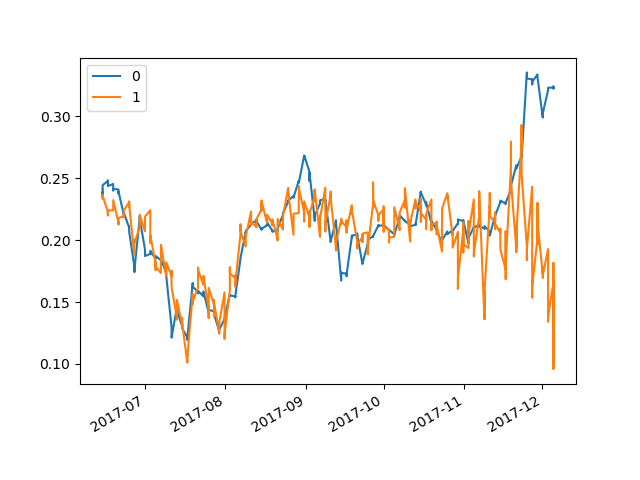

In [318]:
r = trained_model7.model.predict(test_features)

x = test_labels.flatten()
y = r.flatten()
d = np.column_stack((x,y))
%matplotlib notebook
cv_time = output_times[training_size:test_size,:].flatten()
pd.DataFrame(index=cv_time,data=d).plot(kind=("line"))

**note to self: adding 2 day lag helps alot**

In [176]:
test_labels

array([[0.23852057, 0.23641018, 0.23500325, 0.24126399, 0.2412561 ,
        0.24442647],
       [0.24767729, 0.24836901, 0.24766561, 0.24713274, 0.24625868,
        0.24365587],
       [0.24534263, 0.24309309, 0.24282056, 0.24245998, 0.2399275 ,
        0.24133443],
       [0.24091235, 0.23869644, 0.23852057, 0.23753572, 0.23852052,
        0.23922404],
       [0.22061036, 0.22250965, 0.22163742, 0.22163742, 0.22163742,
        0.22212985],
       [0.21038199, 0.21108545, 0.21038199, 0.20756813, 0.20820124,
        0.20686471],
       [0.17840248, 0.17661568, 0.17942954, 0.18069577, 0.17412649,
        0.17626395],
       [0.217392  , 0.21861252, 0.21699455, 0.21952696, 0.21790712,
        0.21685386],
       [0.19258433, 0.19168839, 0.19163465, 0.18716765, 0.18777421,
        0.18716468],
       [0.18892631, 0.18997158, 0.18927804, 0.18853138, 0.18948205,
        0.19131814],
       [0.18477587, 0.18540794, 0.18646207, 0.1859393 , 0.18646419,
        0.18716765],
       [0.18372067, 0

<IPython.core.display.Javascript object>


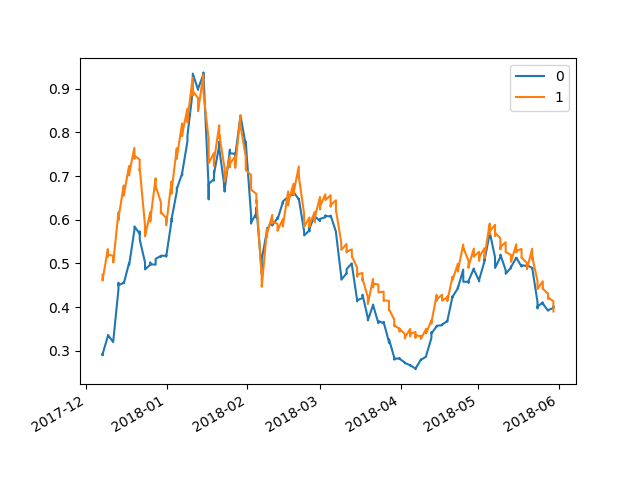

In [320]:
import seaborn as sns

cv_time = output_times[test_size:validation_size,:].flatten()

validation_data = trained_model2.model.predict(validation_features)

x = validation_labels.flatten()
y = validation_data.flatten()
d = np.column_stack((x,y))

%matplotlib notebook
pd.DataFrame(index=cv_time,data=d).plot(kind=("line"))

<IPython.core.display.Javascript object>


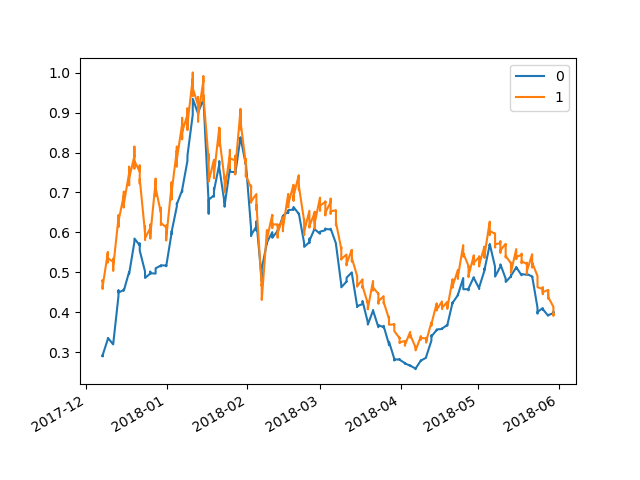

In [225]:
import seaborn as sns

cv_time = output_times[test_size:validation_size,:].flatten()

validation_data = trained_model2.model.predict(validation_features)

x = validation_labels.flatten()
y = validation_data.flatten()
d = np.column_stack((x,y))

%matplotlib notebook
pd.DataFrame(index=cv_time,data=d).plot(kind=("line"))

<IPython.core.display.Javascript object>


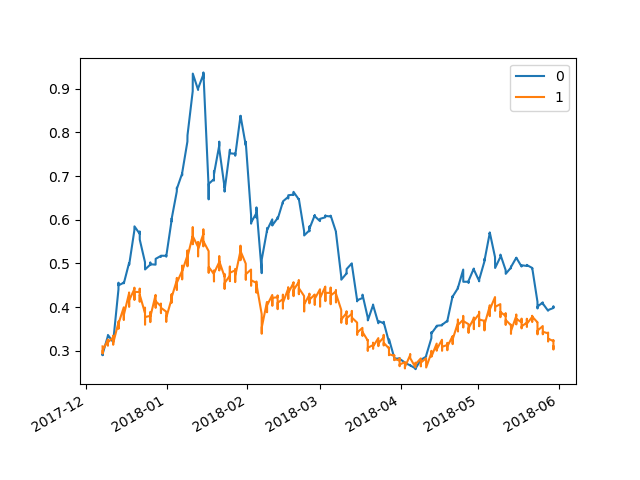

In [227]:
import seaborn as sns

cv_time = output_times[test_size:validation_size,:].flatten()

validation_data = trained_model3.model.predict(validation_features)

x = validation_labels.flatten()
y = validation_data.flatten()
d = np.column_stack((x,y))

%matplotlib notebook
pd.DataFrame(index=cv_time,data=d).plot(kind=("line"))

# Plot Results

In [93]:
test_labels.shape

(74, 36, 10)

# Messing Around

In [32]:
Y_closing_eth_price = Y[:,0,0]
Y_market_movement = Y[:,0,9]
Y.shape

(245, 36, 10)

In [27]:
Y[:,0,0]

array([0.00098069, 0.00098069, 0.00098069, ..., 0.34931876, 0.34929688,
       0.34917204])

In [28]:
Y[:,35,0]

IndexError: index 35 is out of bounds for axis 1 with size 1

In [ ]:
0.00082603/0.00062919

In [33]:
np.seterr(divide='ignore', invalid='ignore')
np.divide(Y[:,0,0],Y[:,35,0]) 

array([0.76170337, 0.99103138, 0.72173916, 0.92831543, 1.        ,
       1.        , 0.95933611, 1.        , 0.84570564, 1.        ,
       1.        , 1.13685732, 1.05023926, 1.        , 1.        ,
       0.96272123, 1.08987612, 0.99156113, 1.04733728, 0.94960618,
       0.92252675, 0.94071232, 0.95480225, 1.04692387, 1.00000046,
       0.93842781, 1.01155952, 0.99677818, 0.97314251, 0.98384047,
       0.98369361, 0.96399787, 1.00000001, 1.        , 1.01469298,
       0.99125992, 0.95898438, 0.95862624, 1.07647969, 1.01511382,
       1.00474268, 0.98181818, 0.99587629, 0.97036283, 1.03707137,
       1.07389749, 0.9747245 , 0.99832432, 0.88248892, 0.91174036,
       1.01297355, 0.9607204 , 1.00386742, 0.96307526, 0.9888395 ,
       1.00628617, 0.95584706, 1.01216344, 0.97194116, 0.97675893,
       1.01976349, 0.99021012, 0.97725981, 1.00443143, 1.0085701 ,
       0.96059384, 0.96871602, 0.99842379, 1.06438467, 0.95325248,
       1.00640741, 1.        , 0.98798595, 1.13367361, 0.91161

In [31]:
Y.shape

(149960, 1, 10)

In [126]:
np.average(np.divide(Y[0:100000,0,0],Y[0:100000,35,0]) < 1)

0.49387755102040815

In [125]:
np.average(np.divide(Y[0:100000,0,0],Y[0:100000,35,0]) > 1)

0.47346938775510206

In [96]:
r_1 = Y[0:100000,0,0]
r_2 = Y[0:100000,35,0]
r_3 = np.divide(r_1,r_2)

r_c_lt = r_3 < 1
r_c_gt = r_3 > 1


/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
np.average(r_3[r_c_lt])

0.9713363119724743

In [101]:
(np.average(r_3[r_c_gt][1:7054]) + np.average(r_3[r_c_gt][7055:]))/2

1.0422773815639128

In [90]:
r_3[r_c][7053:7055]
# point 7055 has an inf for what ever reason.....

array([1.00766735,        inf])

In [54]:
np.average(r_3[r_c])

inf

In [44]:
np.divide(Y[0:100000,0,0],Y[0:100000,35,0])

/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.76170337, 0.76170337, 0.73662672, ..., 1.00539378, 0.99584584,
       0.99255389])

/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


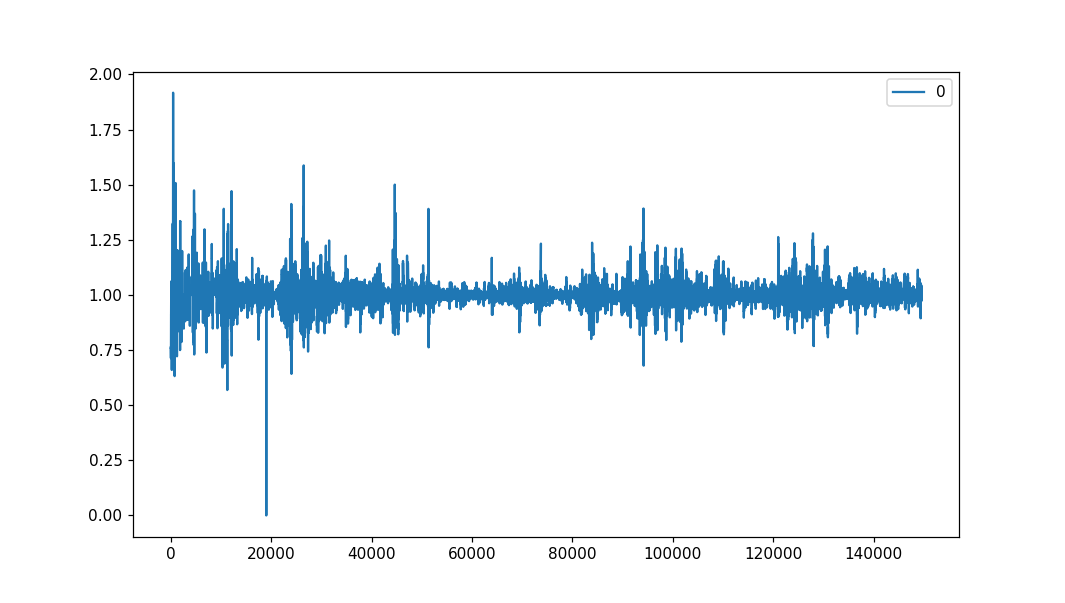

In [23]:
# 6 hours interval eth closing price % change
%matplotlib notebook
pd.DataFrame(np.divide(Y[:,0,0],Y[:,35,0])).plot(kind="line")

In [39]:

xx = Y[:,0,0] 

xxx = xx == 0
xx[xxx]

array([0.])

In [22]:
X.shape

(149605, 576, 8)

In [24]:
# labels for up/down behavior 
Y[:,0,0].shape

(149605,)